# Adult - Error Detection using GRUs

In [58]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import h5py
import pickle
from sklearn.model_selection import train_test_split
from numpy.random import seed
import time

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import models
from keras import layers
from keras import optimizers
from keras import activations
from keras import losses
from keras import metrics
from keras.utils import to_categorical
from keras.models import load_model

import matplotlib.pyplot as plt
%matplotlib inline

In [59]:
seed(42)

## Read the data

In [60]:
#df = pd.read_csv('train_test_hosp_dataset.csv', encoding='utf8',dtype=object)

In [61]:
df = pd.read_csv('adult_final_train.csv', encoding='utf8',dtype=object)
df = df.sample(frac=1)

In [62]:
start = time.time()

In [63]:
df.head(3)

,age,workclass,education,educationnum,maritalstatus,occupation,relationship,race,sex,hoursperweek,country,income,label
3643,53,private,some-college,10,married-civ-spouse,machine-op-inspct,xusband,white,male,40,united-states,<=50k,0
16036,18,empty,11th,x,never-married,empty,own-child,white,male,25,united-states,<=50k,0
9401,42,privatx,some-college,10,married-civ-spouse,machine-op-inspct,wife,white,female,37,united-states,>50k,0


In [64]:
df['label'].value_counts()

1    17679
0    14858
Name: label, dtype: int64

### Separate the labels from the training data

In [65]:
df['label'] = df['label'].apply(lambda x: int(float(x)))
labels = np.asarray(df['label'].tolist())

In [66]:
df.drop(columns=['label'], axis=1, inplace=True)

In [67]:
df.shape

(32537, 12)

### Convert each row to a space separated string

In [68]:
dfList = df.values.tolist()

In [69]:
dfCol = df.columns.tolist()

In [70]:
rows = []
for row in dfList:
    combined = ':'.join([str(x) for x in row])
    rows.append(combined)

In [71]:
testSet= []
labels_test = []
for i in range(int(0.05*len(rows)), len(rows)):
    testSet.append(rows[i])
    labels_test.append(labels[i])
index = np.arange(len(testSet))

In [72]:
max([len(r) for r in rows])

128

In [73]:
count = sum(df.nunique())
count

901

In [74]:
df.nunique()

age               92
workclass         76
education        108
educationnum      25
maritalstatus     73
occupation       175
relationship      58
race              37
sex               12
hoursperweek     113
country          121
income            11
dtype: int64

### Save the dataset

In [75]:
df.to_csv("AdultTrainingDataMultiAttributes.csv", encoding='utf8', index=False)

## Tokenize the data

In [76]:
maxSequenceLength = max([len(r) for r in rows])
maxWords = int(2 * count)

In [77]:
tokenizer = Tokenizer(num_words=maxWords, split=':')
tokenizer.fit_on_texts(rows)
sequences = tokenizer.texts_to_sequences(rows)
word_index = tokenizer.word_index

In [78]:
len(word_index)

763

In [79]:
data = pad_sequences(sequences, maxlen=maxSequenceLength)

## Train test split

### Store the test data

In [80]:
indices = np.arange(data.shape[0])

In [81]:
data = data[indices]
labels = labels[indices]

In [82]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.95)

In [83]:
len(X_train), len(y_train)

(1626, 1626)

In [84]:
len(X_test), len(y_test)

(30911, 30911)

## Model
**Architecture**
* 1 Embedding layer
* 1 Bidirectional GRU layer
* 1 output layer, _sigmoid_ activation
* Optimizer: Adam (learning rate = 0.01)
* Loss function: Binary crossentropy loss

In [85]:
embeddingDim = 100

In [86]:
model = models.Sequential()
model.add(layers.Embedding(maxWords, embeddingDim, input_length=maxSequenceLength))
model.add(layers.Bidirectional(layers.GRU(64)))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1, activation=activations.sigmoid))
model.compile(optimizer=optimizers.RMSprop(lr=0.01), loss=losses.binary_crossentropy, metrics=[metrics.binary_accuracy])

In [87]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 128, 100)          180200    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               63360     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 244,201
Trainable params: 243,945
Non-trainable params: 256
_________________________________________________________________


In [88]:
history = model.fit(X_train, y_train,
                    epochs=8,
                    batch_size=32, 
                    validation_split=0.1)

Train on 1463 samples, validate on 163 samples
Epoch 1/8
1463/1463 [==============================] - 7s 5ms/step - loss: 0.5913 - binary_accuracy: 0.6910 - val_loss: 0.6260 - val_binary_accuracy: 0.7730
Epoch 2/8
1463/1463 [==============================] - 6s 4ms/step - loss: 0.1710 - binary_accuracy: 0.9330 - val_loss: 0.3085 - val_binary_accuracy: 0.9264
Epoch 3/8
1463/1463 [==============================] - 5s 4ms/step - loss: 0.0283 - binary_accuracy: 0.9938 - val_loss: 0.4528 - val_binary_accuracy: 0.9141
Epoch 4/8
1463/1463 [==============================] - 6s 4ms/step - loss: 0.0153 - binary_accuracy: 0.9945 - val_loss: 0.8795 - val_binary_accuracy: 0.8773
Epoch 5/8
1463/1463 [==============================] - 5s 4ms/step - loss: 0.0389 - binary_accuracy: 0.9884 - val_loss: 0.9044 - val_binary_accuracy: 0.9018
Epoch 6/8
1463/1463 [==============================] - 6s 4ms/step - loss: 0.0225 - binary_accuracy: 0.9897 - val_loss: 0.4767 - val_binary_accuracy: 0.9080
Epoch 7/8
1

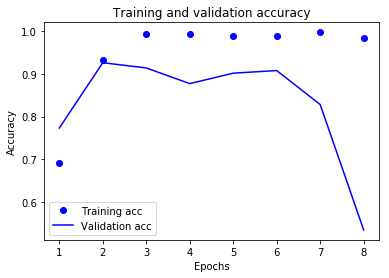

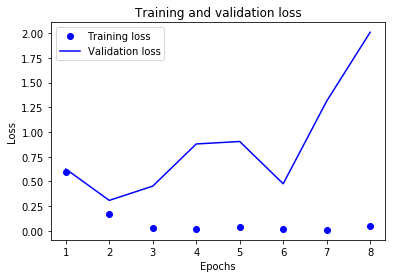

In [89]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show();

In [90]:
print("Training time" + str(time.time() - start))

Training time51.36280608177185


## Evaluation on test set

In [91]:
results = model.evaluate(X_test, y_test)

30911/30911 [==============================] - 25s 825us/step


## Save the model and tokenizer for future use

In [92]:
model.save("AdultErrorDetectionMultiAttributeClassifier.h5")

In [93]:
with open('AdultErrorDetectionMultiAttributeTokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL, fix_imports=True)

## Run model on the test dataset

In [94]:
start = time.time()

In [95]:
model = load_model('AdultErrorDetectionMultiAttributeClassifier.h5')

In [96]:
with open('AdultErrorDetectionMultiAttributeTokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
def classifyTuples(model, tokenizer, value):
    value = [value]
    sequences = tokenizer.texts_to_sequences(value)
    testData = pad_sequences(sequences, maxlen=maxSequenceLength)
    predictions = model.predict(testData)
    return int(predictions[0] >= 0.5)

In [ ]:
ourLabels = []

#for row in rows:
#    label = classifyTuples(model, tokenizer, row)
#    ourLabels.append(row + ':' + str(label))
for row in testSet:
    label = classifyTuples(model, tokenizer, row)
    ourLabels.append(row + ':' + str(label))

In [ ]:
len(ourLabels)

In [ ]:
with open('AdultDatasetPredictions.pkl', 'wb') as f:
    pickle.dump(ourLabels, f)

In [ ]:
ourLabels = np.asarray(ourLabels)
ourLabels = ourLabels[index]

## Get only the faulty tuples

In [ ]:
with open('AdultDatasetPredictions.pkl', 'rb') as f:
    ourLabels = pickle.load(f)

In [ ]:
errors_test = [row for row in ourLabels if row[-1] == '0']

In [ ]:
len(errors_test)

In [ ]:
with open('AdultDatasetErrors.pkl', 'wb') as f:
    pickle.dump(errors_test, f)

### Convert pickle to dataframe

In [ ]:
values = [row.split(':') for row in errors_test]

In [ ]:
len(values)

In [ ]:
headers = df.columns.tolist()
headers.append('label')

In [ ]:
df = pd.DataFrame(values, columns=headers)

In [ ]:
df.to_csv('AdultErrors.csv',encoding='utf8',index=False)

## Metrics

In [ ]:
from sklearn.metrics import classification_report

y_pred = []
for i in ourLabels:
    y_pred.append(int(i.split(':')[-1]))
print(classification_report(labels_test, y_pred))

In [ ]:
print("Runtime:" + str(time.time()-start))